# Setup, Training, and Evaluating CNNs for Tree Genera Classification

The following Jupyter Notebook includes code to setup and train a convolutional neural network with Python and Pytorch.

Version: April 2024



In [3]:

# Imports for Pytorch
import torch # version 2.1.2
import torchvision # version 0.16.2
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import v2
import torch.nn as nn # contains base class for all neural network modules
import torch.nn.functional as F #https://pytorch.org/docs/stable/nn.functional.html contains common functions for training NNs (convolutions, losses, etc..)
from sklearn.metrics import classification_report



# Image processing and display
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Other Imports
import os
import shutil
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import time


## Setup new testing and training datasets, save their metadata as csvs, and print number of images to console

### Functions to create new testing and training datasets, export metadata, and print number of images to the console

In [5]:
import os
# Functions to create datasets for training and testing, export metadata to csv, and print directory information
# Function to export metadata to csv
def process_existing_files(root_directory, csv_path, export_csv=False):
    """
    Process existing files in the root directory and write to csv.

    Parameters:
    root_directory (str): The path to the root directory containing images of tree genera.

    Returns:
    Print statement with the file path to the csv.
    """
    existing_files = {}

    # Get the list of genus names from the root directory
    genera = os.listdir(root_directory)

    for genus in genera:
        genus_dir = os.path.join(root_directory, genus)
        genus_files = os.listdir(genus_dir)
        existing_files[genus] = genus_files

    # Create a dataframe from the dictionary
    df = pd.DataFrame(existing_files.items(), columns=['genus', 'files'])
    df = df.explode('files')

    # Add additional column for data source
    if "inat" in root_directory.lower():
        df['data_source'] = "iNaturalist"
    else:
        df['data_source'] = "Autoarborist"
    
    if export_csv:
        # Write to csv
        csv_filepath = os.path.join(csv_path, os.path.basename(root_directory) + ".csv")
        df.to_csv(csv_filepath, index=False)
        print(f"Existing files for {root_directory} written to csv.")
    else:
        return df
    
# Function to print directory information
def print_directory_info(root_directory):
    """
    Print the number of files in each directory in the root directory.

    Parameters:
    root_directory (str): The path to the root directory containing images of tree genera.

    Returns:
    Print statement with the number of files in each directory.
    """
    for genus_folder in os.listdir(root_directory):
        genus_path = os.path.join(root_directory, genus_folder)
        
        # Check if it's a directory
        if os.path.isdir(genus_path):
            # Count the number of files in the directory
            num_files = len([f for f in os.listdir(genus_path) if os.path.isfile(os.path.join(genus_path, f))])
            
            print(f"Directory: {genus_folder}, Number of Files: {num_files}")
    return None

# Function to create datasets for training and testing: Autoarborist or iNaturalist
def create_datasets (training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root, 
                     training_destination_root, existing_training_root, existing_testing_root, append, csv_path):
    """
    Create training and testing datasets for selected genera from any source image dataset.
    
    Parameters:
    training_ratio (float): The ratio of training images to total images.
    max_training_images_og (int): The maximum number of training images to select.
    max_testing_images_og (int): The maximum number of testing images to select.
    selected_genera (list): The list of selected genera to include in the training and testing datasets.
    source_root (str): The path to the source directory containing all available images of tree genera from Autoarborist.
    testing_destination_root (str): The path to the destination directory for images of tree genera as testing data.
    training_destination_root (str): The path to the destination directory for images of tree genera as training data.
    existing_training_root (str): The path to the existing directory containing images of tree genera as training data used in previous experiments.
    existing_testing_root (str): The path to the existing directory containing images of tree genera as testing data used in previous experiments.
    append (bool): A logical statement to append new images to existing training and testing data.
    
    Returns:
    None
    """
    # Iterate through the source directory
    for genus_folder in os.listdir(source_root):
        max_training_images = max_training_images_og
        max_testing_images = max_testing_images_og
        # Keep track of starting time
        start_time = time.time()
        genus_path = os.path.join(source_root, genus_folder) # Get path to images for each genera
    
        # List all images in the current genus folder. Some images are .jpg and .jpeg format.
        # If "inat" is found anywhere in the genus folder name, then the images are in the root folder.
        if "inat" in genus_path.lower():
            images = [image for image in os.listdir(genus_path) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            images = [image for image in os.listdir(os.path.join(genus_path, 'images')) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Only select genera with >100 images.
        if len(images) > 100:
            # Check if it's a directory and if it's in the selected genera list
            if os.path.isdir(genus_path) and genus_folder in selected_genera:
                # Create destination folders for the training and testing data for the current genus
                training_destination_genus_path = os.path.join(training_destination_root, genus_folder)
                testing_destination_genus_path = os.path.join(testing_destination_root, genus_folder)
                os.makedirs(training_destination_genus_path, exist_ok=True)
                os.makedirs(testing_destination_genus_path, exist_ok=True)
                # Append new images to existing training and testing data
                if append:
                    print(f"Copying existing images for {genus_folder} to new training and testing folders.")
                    existing_training_genus_path = os.path.join(existing_training_root, genus_folder)
                    existing_testing_genus_path = os.path.join(existing_testing_root, genus_folder)

                    # Copy existing training images to the new training destination folder
                    for image in os.listdir(existing_training_genus_path):
                        source_image_path = os.path.join(existing_training_genus_path, image)
                        destination_image_path = os.path.join(training_destination_genus_path, image)
                        _= shutil.copy2(source_image_path, destination_image_path)

                    # Copy existing testing images to the new testing destination folder
                    for image in os.listdir(existing_testing_genus_path):
                        source_image_path = os.path.join(existing_testing_genus_path, image)
                        destination_image_path = os.path.join(testing_destination_genus_path, image)
                        _= shutil.copy2(source_image_path, destination_image_path)

                    # Update the max_training_images and max_testing_images
                    max_training_images = max_training_images - len(os.listdir(existing_training_genus_path))
                    max_testing_images = max_testing_images - len(os.listdir(existing_testing_genus_path))
                    print(f"Updated max_training_images: {max_training_images}, max_testing_images: {max_testing_images}")

                    # Update images to exclude the existing training and testing images
                    print(f"Total number of available images: {len(images)} for {genus_folder}...")
                    existing_training_images = set(os.listdir(existing_training_genus_path))
                    existing_testing_images = set(os.listdir(existing_testing_genus_path))
                    images = [image for image in images if image not in existing_training_images and image not in existing_testing_images]
                    print(f"Total number of images after excluding existing training and testing images: {len(images)} for {genus_folder}...")

                # Randomly select a number of images from the folder here: (900 training + 100 testing).
                if len(images) > max_training_images + max_testing_images:
                    images = random.sample(images, max_training_images + max_testing_images) # file paths for images

                # Randomly divide images into training and testing sets
                num_total_images = len(images)
                num_training_images_to_copy = min(int(num_total_images * training_ratio), max_training_images)

                # Randomly shuffle the images before moving
                random.shuffle(images)

                # Split images into training and testing sets
                training_images = images[:num_training_images_to_copy]
                testing_images = images[num_training_images_to_copy:]
            
                # Copy training images to the training destination folder
                print(f"Copying new images for {genus_folder} to new training and testing folders.")
                for image in training_images:
                    if "inat" in genus_path.lower():
                        source_image_path = os.path.join(genus_path, image)
                    else:
                        source_image_path = os.path.join(genus_path, 'images', image)
                    destination_image_path = os.path.join(training_destination_genus_path, image)
                    _= shutil.copy2(source_image_path, destination_image_path)

                # Copy testing images to the testing destination folder
                for image in testing_images:
                    if "inat" in genus_path.lower():
                        source_image_path = os.path.join(genus_path, image)
                    else:
                        source_image_path = os.path.join(genus_path, 'images', image)
                    destination_image_path = os.path.join(testing_destination_genus_path, image)
                    _= shutil.copy2(source_image_path, destination_image_path)
                # Keep track of ending time
                end_time = time.time()
                # Report time take in minutes
                total_time = (end_time - start_time) / 60
                print(f"Images copied successfully for {genus_folder}. Time taken: {total_time} minutes.")
    print(f"All images copied successfully for: {selected_genera}.")
    process_existing_files(training_destination_root, csv_path, export_csv=True)
    return None



# Function to combine existing training and testing data

def combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root):
    """
    Combine the training datasets from Autoarborist and iNaturalist into a single testing or training dataset.
    Combine the testing datasets from Autoarborist and iNaturalist into a single testing or training dataset.
    Combine the metadata from Autoarborist and iNaturalist into a single metadata file.

    Parameters:
    autoarborist_dataset_root (str): The path to the Autoarborist testing or training dataset.
    inaturalist_dataset_root (str): The path to the iNaturalist testing or training dataset.
    combined_dataset_root (str): The path to the combined testing or training dataset.

    Returns:
    None
    """
    # Create the combined training dataset directory
    os.makedirs(combined_dataset_root, exist_ok=True)

    # Copy the Autoarborist dataset to the combined dataset
    for genus_folder in os.listdir(autoarborist_dataset_root):
        genus_path = os.path.join(autoarborist_dataset_root, genus_folder)
        destination_genus_path = os.path.join(combined_dataset_root, genus_folder)
        os.makedirs(destination_genus_path, exist_ok=True)
        print(f"Copying Autoarborist images for {genus_folder} to the combined dataset.")

        for image in os.listdir(genus_path):
            source_image_path = os.path.join(genus_path, image)
            destination_image_path = os.path.join(destination_genus_path, image)
            _= shutil.copy2(source_image_path, destination_image_path)
        
    
    # Copy the iNaturalist dataset to the training dataset
    for genus_folder in os.listdir(inaturalist_dataset_root):
        genus_path = os.path.join(inaturalist_dataset_root, genus_folder)
        destination_genus_path = os.path.join(combined_dataset_root, genus_folder)
        os.makedirs(destination_genus_path, exist_ok=True)
        print(f"Copying iNaturalist images for {genus_folder} to the combined dataset.")

        for image in os.listdir(genus_path):
            source_image_path = os.path.join(genus_path, image)
            destination_image_path = os.path.join(destination_genus_path, image)
            _= shutil.copy2(source_image_path, destination_image_path)

    print(f"Combined dataset created successfully.")

    # Combine the autoarborist_root, inaturalist_root, and combined_root metadata
    roots = [autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root]
    updated_roots = [os.path.join(os.path.join(root.rsplit('\\', 1)[0], os.path.basename(root) + ".csv")) for root in roots]
    
    # Pull in the existing metadata for autoarborist
    autoarborist_metadata = pd.read_csv(updated_roots[0])
    # Pull in the existing metadata for inaturalist
    inaturalist_metadata = pd.read_csv(updated_roots[1])
    # Combine the metadata
    combined_metadata = pd.concat([autoarborist_metadata, inaturalist_metadata], ignore_index=True)
    # Write to csv
    combined_metadata.to_csv(updated_roots[2], index=False)
    print(f"Combined metadata written to csv.")
    return None

# Constants
selected_genera = ['acer','ailanthus','betula','citrus','fraxinus','gleditsia','juglans','juniperus', 'magnolia','phoenix','picea',
                   'pinus','prunus','pseudotsuga','pyrus','quercus','rhus','sequoia','taxodium', 'thuja','tilia','ulmus','washingtonia']
training_ratio = 0.9 # ratio of training images to total images
max_training_images_og = 1187 # maximum number of training images to select
max_testing_images_og = 132 # maximum number of testing images to select


### Autoarborist: Source, append, and create new testing and training datasets

In [ ]:
# Source: contains all available street view images of tree genera from Autoarborist
source_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\autoarborist_original_data\autoarborist_original_jpegs\jpegs_streetlevel_genus_idx_label"

# Target: location for images of tree genera as training data 
training_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_apr624"

# Target: location for images of tree genera as testing data 
testing_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as training data used in previous experiments
existing_training_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_march624"

# Existing Target: location for existing images of tree genera as testing data used in previous experiments
existing_testing_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_march624"

# Append: logical statement to append new images to existing training and testing data
append = True

# CSV path: location to save the CSV file containing the training and testing data
csv_path = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist"

# Select all genera
#selected_genera = os.listdir(source_root)
# create_datasets(training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root,
#                     training_destination_root, existing_training_root, existing_testing_root, append)

# Export metadata for existing training and testing data
process_existing_files(training_destination_root, csv_path, export_csv=True)
process_existing_files(testing_destination_root, csv_path, export_csv=True)

### Autoarborist: Print the number of images for the new training and testing directories

In [ ]:
# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

### iNaturalist: Source, append, and create new testing and training datasets for images

In [ ]:
# Set the paths for Autoarborist training and testing data

# Source: contains all available street view images of tree genera from iNaturalist
source_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inat\images\original_10k"

# Target: location for images of tree genera as training data 
training_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"

# Target: location for images of tree genera as testing data 
testing_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as training data used in previous experiments
existing_training_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as testing data used in previous experiments
existing_testing_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"

# Append: logical statement to append new images to existing training and testing data
append = True

# CSV path: location to save the CSV file containing the training and testing data
csv_path = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist"

# Select all genera
selected_genera = os.listdir(source_root)
create_datasets(training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root,
                    training_destination_root, existing_training_root, existing_testing_root, append,csv_path)

### iNaturalist: Print the number of images for the new training and testing directories

In [ ]:
# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

### Autoarborist + iNaturalist: Combine Training and Testing Records

In [ ]:
# Combine the training datasets

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_apr624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\training_dataset_small_apr624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_apr624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\testing_dataset_small_apr624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

In [ ]:
# DELETE CODE CHUNK AFTER PROCESSING

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_march624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_march624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\training_dataset_small_march624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_march624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_march624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\testing_dataset_small_march624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

### Autoarborist + iNaturalist: Print the number of images for the new training and testing directories

In [ ]:
training_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\training_dataset_small_apr624"
testing_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\testing_dataset_small_apr624"

# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

## Setup EfficientNetv2 model to run experiments

In [6]:
# Functions to prepare a Basic Model for Image Classification

class ImageClassificationBase(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    # Define a base class with functionality for model training, validation, and evaluation per epoch
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Functions to define a CNN Model using EfficientNetV2-S

class EfficientNetImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Load the pre-trained EfficientNetV2-L Model
        self.network = torchvision.models.efficientnet_v2_s(pretrained=True)
        # Modify the final fully connected layer to match the number of classes in your dataset
        num_classes = len(train_dataset.classes)
        in_features = self.network.classifier[1].in_features
        self.network.classifier = nn.Linear(in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

# Functions  to visualize training data
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0)) #reshape image from (3, H, W) to (H, W, 3)

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

# Functions to define GPU device and load data to GPU
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)


# Functions to define training and evaluation functions

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit model
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    # Create optimizer with initial learning rate
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        start = time.time()
        print(f"Starting epoch {epoch+1}")
        model.train()
        train_losses = []
        
        for batch in train_loader:
            # Forward pass: prediction & calculate loss
            loss = model.training_step(batch)
            train_losses.append(loss)
            # Backward pass: backpropagate loss & calculate gradients
            loss.backward()
            optimizer.step() #update gradients
            optimizer.zero_grad() #zero gradients for next training forward pass
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        end = time.time()
        total = end-start/60
        print(f"Time taken for epoch {epoch+1}: {total} minutes")
        
    return history

# Functions to visualize the results

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    # Reduce plot margins
    plt.autoscale()
    plt.margins(0.2)
    plt.show()

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    # Reduce plot margins
    plt.autoscale()
    plt.margins(0.2)
    plt.show()

# Constant variables: number of epochs, optimizer function, learning rate, warmup epochs, and training and testing data paths
selected_genera = ['acer','ailanthus','betula','citrus','cupaniopsis','erythrina','fraxinus','gleditsia','juglans','juniperus',
                   'magnolia','phoenix','picea','pinus','prunus','pseudotsuga','pyrus','quercus','rhus','sequoia','taxodium',
                   'thuja','tilia','ulmus','washingtonia']
num_epochs = 10
opt_func = torch.optim.Adam
base_lr = 0.001
training_destination_root = r"D:\blaginh\tree_classification\aa_inat_combined\training_dataset_small_march624"
testing_destination_root = r"D:\blaginh\tree_classification\aa_inat_combined\testing_dataset_small_march624"
testing_destination_root_aa = r"D:\blaginh\tree_classification\autoarborist\testing_dataset_small_march624"
testing_destination_root_inat = r"D:\blaginh\tree_classification\inat\testing_dataset_small_march624"

### Experiment 1: The effect of decreased resolution (512x512) on CNN image classification performance.

Hypothesis: decreased resolution will result in decreased performance.

#### Define Image Augumentations - Update paths

In [ ]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    #v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    #v2.Resize(size=(512, 512), antialias=True),
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

#### Define training, validation, and testing data loaders

In [ ]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

In [ ]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [ ]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

#### Fit and Save Model & Model History - update paths

In [ ]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation - update path

In [ ]:
# Load a pre-trained model
model_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - updath path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_inatonly.csv")

### Experiment 2: The effect of increased resolution (768x768) on CNN image classification performance.

Hypothesis: increased resolution will result in increased performance.

#### Define Image Augumentations - Update paths

In [ ]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    #v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomResizedCrop(size=(768, 768), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    #v2.Resize(size=(512, 512), antialias=True),
    v2.Resize(size=(768, 768), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

#### Define training, validation, and testing data loaders

In [ ]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

In [ ]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))
print("Classes in the Testing Dataset (iNaturalist Only) : /n", len(test_dataset_inat.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [ ]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

#### Fit and Save Model & Model History - update paths

In [ ]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation

In [ ]:
# Load a pre-trained model
model_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_inatonly.csv")

### Experiment 3: The effect of random crop on CNN image classification performance.

Hypothesis: random cropping will increased the model's performance on classifying autoarborist, decrease the model's performance on classifying inaturalist, and decreasing the model's performance on classifying autoarborist + inaturalist

#### Define Image Augumentations - Update paths

In [12]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(size=(512,512), pad_if_needed = True),
    v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

Dataset ImageFolder
    Number of datapoints: 44899
    Root location: D:\blaginh\tree_classification\aa_inat_combined\training_dataset_small_march624
    StandardTransform
Transform: Compose(
                 ToImage()
                 RandomCrop(size=(512, 512), pad_if_needed=True, fill=0, padding_mode=constant)
                 RandomResizedCrop(size=(512, 512), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

torch.Size([3, 512, 512]) 0


#### Define training, validation, and testing data loaders

In [14]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

Length of Train Data : 42899
Length of Validation Data : 2000
Number of Model Parameters:  20209513


#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes in the Training Dataset : /n 25
Classes in the Testing Dataset : /n 25
Classes in the Testing Dataset (Autoarborist Only) : /n 25
Classes in the Testing Dataset (iNaturalist Only) : /n 25
Label : acer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


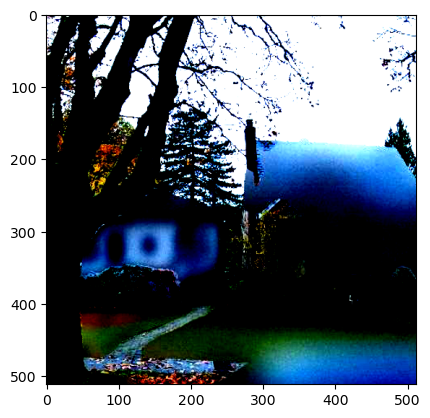

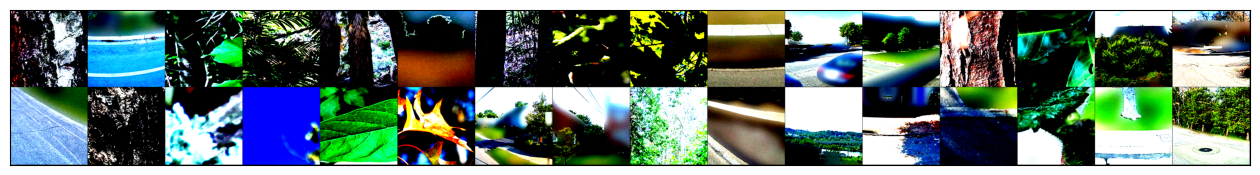

In [15]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))
print("Classes in the Testing Dataset (iNaturalist Only) : /n", len(test_dataset_inat.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [16]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

device(type='cuda')

EfficientNetImageClassification(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           

#### Fit and Save Model & Model History - update paths

In [17]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r'D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

Starting epoch 1


#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation

In [ ]:
# Load a pre-trained model
model_path = r'D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_inatonly.csv")